# WorkShop: Text Analysis II


## 📚 Objetivos del Taller 📚

- Explicar el problema de la representación Bag of Words.
- Motivación y repaso de qué son los Word Embeddings.
- Explicación de Word2Vec.
- Entrenar nuestros propios `word embeddings` usando un dataset con fuentes de noticias de diversos medios. 💪
- Utilizaremos estos embeddings pre-entrenados para mejorar la capacidad de nuestros modelos en tareas nuevas y en la resuelta en el auxiliar pasado.
- Conocer los `contextualized word embeddings` a través de `BETO`.

## **Motivación**

Partamos por decir que una red neuronal no es más que una serie de operaciones matemáticas sobre vectores con una gran cantidad de dimensiones (tensores). Por ende, si queremos entrenar un modelo necesitamos transformar el texto original a vectores numéricos.

Una de las soluciones más simples a este problema es la representación de Bag of Words (BoW). Si aplicamos este método a cada palabra de cada documento, tendremos un vector one hot encoding por cada palabra. Esto quiere decir que tendremos vectores del largo del vocabulario $V$, con un 1 en la posición asociada a la palabra representada.

Y estamos listos? Podemos entrenar redes neuronales?

La verdad es que no es así, y es que estamos ignorando un gran problema con este enfoque. 😞


### El gran problema de Bag of Words

Pensemos en estas 3 frases como documentos:

- $doc_1$: `¡Buenísima la marraqueta!`
- $doc_2$: `¡Estuvo espectacular ese pan francés!`
- $doc_3$: `!Buenísima esa pintura!`

Sabemos $doc_1$ y $doc_2$ hablan de lo mismo 🍞🍞👌 y que $doc_3$ 🎨 no tiene mucho que ver con los otros.

Supongamos que queremos ver que tan similares son ambos documentos.
Para esto, generamos un modelo `Bag of Words` sobre el documento, aplicando este método por cada palabra para luego tener la representación final.


Es decir, transformamos cada palabra a un vector one-hot y luego los sumamos por documento.

Por simplicidad, omitiremos algunas stopwords y consideramos pan frances como un solo token. Así nos quedaría el siguiente vocabulario:

$$v = \{buenísima, marraqueta, estuvo, espectacular, pan\ francés, pintura\}$$

Entonces, el $\vec{doc_1}$ quedará:

$$\begin{bmatrix}1 \\ 0 \\ 0 \\ 0 \\ 0\\ 0\end{bmatrix} +
  \begin{bmatrix}0 \\ 1 \\ 0 \\ 0 \\ 0\\ 0\end{bmatrix} =
  \begin{bmatrix}1 \\ 1 \\ 0 \\ 0 \\ 0\\ 0\end{bmatrix}$$

El $\vec{doc_2}$ quedará:

$$\begin{bmatrix}0 \\ 0 \\ 1 \\ 0 \\ 0\\ 0\end{bmatrix} +
  \begin{bmatrix}0 \\ 0 \\ 0 \\ 1 \\ 0\\ 0\end{bmatrix} +
  \begin{bmatrix}0 \\ 0 \\ 0 \\ 0 \\ 1\\ 0\end{bmatrix} =
  \begin{bmatrix}0 \\ 0 \\ 1 \\ 1 \\ 1\\ 0\end{bmatrix}$$

Y el $\vec{doc_3}$:

$$\begin{bmatrix}1 \\ 0 \\ 0 \\ 0 \\ 0\\ 0\end{bmatrix} +
  \begin{bmatrix}0 \\ 0 \\ 0 \\ 0 \\ 0\\ 1\end{bmatrix} =
  \begin{bmatrix}1 \\ 0 \\ 0 \\ 0 \\ 0\\ 1\end{bmatrix}$$



**¿Cuál es el problema?**

`buenísima` $\begin{bmatrix}1 \\ 0 \\ 0 \\ 0 \\ 0 \\0\end{bmatrix}$ y `espectacular` $ \begin{bmatrix}0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0\end{bmatrix}$ representan ideas muy similares. Por otra parte, sabemos que `marraqueta` $\begin{bmatrix}0 \\ 1 \\ 0 \\ 0 \\ 0 \\0\end{bmatrix}$ y `pan francés` $\begin{bmatrix}0 \\ 0 \\ 0 \\ 0 \\ 1 \\0\end{bmatrix}$ se refieren al mismo objeto. Pero en este modelo, estos **son totalmente distintos**. Es decir, los vectores de las palabras que `buenísima` y `espectacular` son tan distintas como `marraqueta` y `pan francés`. Esto se debe a que cada palabra ocupa una dimensión distinta a las demás y son completamente independientes. Esto evidentemente, repercute en la calidad de los modelos que creamos a partir de nuestro Bag of Words.

![BoW](https://raw.githubusercontent.com/dccuchile/CC6205/master/tutorials/recursos/BoW-Problem.png)



Ahora, si queremos ver que documento es mas similar a otro usando distancia euclidiana, veremos que:

$$d(doc_1, doc_2) = 2.236$$
$$d(doc_1, doc_3) = 1.414$$

Es decir, $doc_1$ se parece mas a $doc_3$ aunque nosotros sabemos que $doc_1$ y $doc_2$ nos están diciendo lo mismo!


Nos gustaría que eso no sucediera. Que existiera algún método que nos permitiera hacer que palabras similares tengan representaciones similares. Y que con estas, representemos mejor a los documentos, sin asumir que en el espacio son geométricamente equidistantes, ya que esto no es verdad en la vida real.


--------------------

## **Hipótesis Distribucional**

Estamos buscando algún enfoque que nos permita representar las palabras de forma no aislada, si no como algo que además capture el significado de esta.

Pensemos un poco en la **hipótesis distribucional**. Esta plantea que:

    "Palabras que ocurren en contextos iguales tienden a tener significados similares."

O equivalentemente,

    "Una palabra es caracterizada por la compañía que esta lleva."

Esto nos puede hacer pensar que podríamos usar los contextos de las palabras para generar vectores que describan mejor dichas palabras: en otras palabras, los `Distributional Vectors`.

Por ejemplo, complete la siguiente frase:

Pintaré la muralla de mi casa de color _____

Puede ser rojo, blanco, mostaza, etc..

Son palabras que a uno se les viene a la mente sólo mirando el contexto entregado, por ende podríamos decir que esas son palabras similares, o al menos muy distintas a Murciélago.


### Opción 1: Word-Context Matrix

Es una matriz donde cada celda $(i,j)$ representa la co-ocurrencia entre una palabra objetivo/centro $w_i$ y un contexto $c_j$. El contexto son las palabras dentro de ventana de tamaño $k$ que rodean la palabra central.

Cada fila representa a una palabra a través de su contexto. Como pueden ver, ya no es un vector one-hot, si no que ahora contiene mayor información.

El tamaño de la matriz es el tamaño del vocabulario $V$ al cuadrado. Es decir $|V|*|V|$.

<img src="https://raw.githubusercontent.com/dccuchile/CC6205/master/slides/pics/distributionalSocher.png" alt="Word-context matrices" style="width: 400px;"/>


**Problema: Creada a partir de un corpus respetable, es gigantezca**.

Por ejemplo, para $|v| = 100.000$, la matriz tendrá $\frac{100000 * 100000 * 4}{10^9} = 40gb $. (Recordando que un entero ocupara 4 bytes)

- Es caro mantenerla en memoria
- Los clasificadores no funcionan tan bien con tantas dimensiones (ver [maldición de la dimensionalidad](https://es.wikipedia.org/wiki/Maldici%C3%B3n_de_la_dimensi%C3%B3n)).

**¿Habrá una mejor solución?**

---------------------

### **Word Embeddings**

Es una de las representaciones más populares del vocabulario de un corpus. La idea principal de los Word Embeddings es crear representaciones vectoriales densas y de baja dimensionalidad $(d << |V|)$ de las palabras a partir de su contexto.

Volvamos a nuestro ejemplo anterior: `buenísima` y `espectacular` ocurren muchas veces en el mismo contexto, por lo que los embeddings que los representan debiesen ser muy similares... (*ejemplos de mentira hechos a mano*):

`buenísima` $\begin{bmatrix}0.32 \\ 0.44 \\ 0.92 \\ .001 \end{bmatrix}$ y `espectacular` $\begin{bmatrix}0.30 \\ 0.50 \\ 0.92 \\ .002 \end{bmatrix}$ versus `marraqueta`  $\begin{bmatrix}0.77 \\ 0.99 \\ 0.004 \\ .1 \end{bmatrix}$ el cuál es claramente distinto.


Pero, ¿Cuál es la utilidad de de crear estos vectores en NLP o en el área de Machine Learning en general?

Supongamos que tienen una enfermedad grave y deben ser operados el día de mañana. Le dan a elegir entre ser operados por un estudiante de primer año de medicina con algo de conocimiento médico o bien ser operados por un niño de 5 años 👶. ¿A quién elegirías?

Espero que tu opción haya sido el estudiante con una pequeña noción de los términos médicos implicados en una intervención así. Algo así es lo que se quiso lograr en el [paper](https://arxiv.org/abs/1301.3781) presentado por Mikolov en 2013, aludiendo a la herramienta **Word2Vec**. La idea es que si quieres resolver por ejemplo una tarea de clasificación de texto, ¿no sería útil utilizar el conocimiento de algún modelo pre-entrenado en una tarea similar de texto?. Claro, sería útil partir con los pesos entrenados por otra red, realizando lo que se llama **transfer learning**.

Ya pero.. ¿Cómo generamos estos vectores? ¿Cómo podemos capturar el contexto? ¿Cuál sería esa task auxiliar a utilizar?



##### **Word2vec y Skip-gram**

Word2Vec es probablemente el paquete de software mas famoso para crear word embeddings utilizando distintos modelos que emplean redes neuronales *shallow* o poco profundas.

Este nos provee herramientas para crear distintos tipos de modelos, tales como `Skip-Gram` y `Continuous Bag of Word (CBOW)`. En este caso, solo veremos `Skip-Gram`.

**Skip-gram** es una task auxiliar con la que crearemos nuestros embeddings. Esta tarea involucra tanto a las palabras y al contexto de ellas. Consiste en que por cada palabra del dataset, debemos predecir las palabras de su contexto (las palabras presentes en ventana de algún tamaño $k$).

![Overview](https://raw.githubusercontent.com/dccuchile/CC6205/master/tutorials/recursos/overview-skipgram.png)

Para resolverla, usaremos una red de una sola capa oculta. Los pesos ya entrenados de esta capa serán los que usaremos como embeddings.

#### Detalles del Modelo

- Como dijimos, el modelo será una red de una sola capa. La capa oculta tendrá una dimensión $d$ la cual nosotros determinaremos. Esta capa no tendrá función de activación. Sin embargo, la de salida si, la cual será una softmax para obtener las distribuciones de probabilidades y así ver cuáles palabras pertenecen o no al contexto.

- El vector de entrada, de tamaño $|V|$, será un vector one-hot de la palabra que estemos viendo en ese momento.

- La salida, también de tamaño $|V|$, será un vector que contenga la distribución de probabilidad de que cada palabra del vocabulario pertenezca al contexto de la palabra de entrada.

- Al entrenar, se comparará la distribución de los contextos con la suma de los vectores one-hot del contexto real.


(marraqueta, Estuvo), (marraqueta, buenisima), (marraqueta, la)
![Skip Gram](https://raw.githubusercontent.com/dccuchile/CC6205/master/tutorials/recursos/Skip-gram.png)


Nota: Esto es computacionalmente una locura. Por cada palabra de entrada, debemos calcular la probabilidad de aparición de todas las otras. Imaginen el caso de un vocabulario de 100.000 de palabras y de 10000000 oraciones...

La solución a esto es modificar la task a *Negative Sampling*. Esta transforma este problema de $|V|$ clases a uno binario.

### La capa Oculta y los Embeddings

Al terminar el entrenamiento, ¿Qué nos queda en la capa oculta?

Una matriz de $v$ filas por $d$ columnas, la cual contiene lo que buscabamos: Una representación continua de todas las palabras de nuestro vocabulario.  

**Cada fila de la matriz es un vector que contiene la representación continua una palabra del vocabulario.**


<img src="http://mccormickml.com/assets/word2vec/word2vec_weight_matrix_lookup_table.png" alt="Capa Oculta 1" style="width: 400px;"/>

¿Cómo la usamos eficientemente?

Simple: usamos los mismos vectores one-hot de la entrada y las multiplicamos por la matriz:

<img src="http://mccormickml.com/assets/word2vec/matrix_mult_w_one_hot.png" alt="Skip Gram" style="width: 400px;"/>

### Visualización

Veamos cómo se ven los embeddings de Word2Vec entrenados sobre un corpus gigante en Inglés. Para facilitar el análisis se reducen las 200 dimensiones a 3. El link a la visualización es el siguiente: Visualización: https://projector.tensorflow.org/

### Espacio multidimensional

Teniendo nuestro embeddings entonces podríamos hacer operaciones tan interesantes como las siguientes:

Manzana + Púrpura -> Ciruela

Rey - Hombre + Mujer -> Reina

Si bien no es posible obtener exactamente dichos vectores, esperaríamos que las palabras más cercanas al vector resultante serían las entregadas, obteniendo así un significado de las palabras según su contexto.


### Fuentes

Word2vec:
- mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
- https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa

Gensim:
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

Nota: Las últimas 2 imagenes pertenecen a [Chris McCormick](http://mccormickml.com/about/)


In [8]:
# Contextualized word embeddings: BERT, ELMO, FLAIR.

x = 'El banco estaba lleno.'
y = 'El banco de sangre necesita personal.'

## **Entrenar nuestros Embeddings**

Para entrenar nuestros embeddings, usaremos el paquete gensim. Este trae una muy buena implementación de `word2vec`.




In [1]:
import re
import pandas as pd
from time import time
from collections import defaultdict
import string
import multiprocessing
import os
import requests
import numpy as np

# word2vec
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.phrases import Phrases, Phraser

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# scikit-learn
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

# visualizaciones
#import matplotlib.pyplot as plt
#import plotly.express as px
#import plotly.graph_objects as go
#from ipywidgets import widgets

### Cargar el dataset y limpiar

Utilizaremos un datos de diversas fuentes de noticias que cuenta con tres atributos principales:

* texto: Referente al texto de la noticia.
* medio: Referente al medio de la noticia.
* fecha: Referente a la fecha de publicación.

In [11]:
dataset = pd.read_csv('https://raw.githubusercontent.com/giturra/sicss-chile-2023/main/text-analysis-II/noticias_oct_dic_2019.tsv', sep='\t')

In [13]:
dataset.head()



,texto,medio,fecha
0,Rey de Tailandia despoja de títulos a su conso...,El Mercurio,2019-10-21 14:51:00
1,Denuncian que personas con epilepsia sufrieron...,El Mercurio,2019-12-18 12:12:00
2,Índice victimización de hogares en el país suf...,El Mercurio,2019-10-15 09:58:00
3,"Meditación, cocina, jardinería, manualidades: ...",El Mercurio,2019-11-16 16:42:00
4,Director de empresa que procesa datos electora...,El Mercurio,2019-11-01 05:25:00


In [15]:
# unir titulo con contenido de la noticia
content = dataset['texto']
content

0       Rey de Tailandia despoja de títulos a su conso...
1       Denuncian que personas con epilepsia sufrieron...
2       Índice victimización de hogares en el país suf...
3       Meditación, cocina, jardinería, manualidades: ...
4       Director de empresa que procesa datos electora...
                              ...                        
9995    Encuentran la mano de un turista desaparecido ...
9996    “El problema grave es que a todos les sirve la...
9997    Alcaldesa de Antofagasta realiza balance de lo...
9998    John Cusack envió su apoyo a las manifestacion...
9999    Zozo, el perro que visita todos los días la tu...
Name: texto, Length: 10000, dtype: object

In [18]:
dataset['medio'].unique()

array(['El Mercurio', 'Cooperativa CL', 'CHV', 'MEGA', 'La Discusión',
       'El Rancaguino', 'La Nación', 'Radio Concierto', 'The Clinic',
       'La RED'], dtype=object)

In [ ]:
content.head()

0    Rey de Tailandia despoja de títulos a su conso...
1    Denuncian que personas con epilepsia sufrieron...
2    Índice victimización de hogares en el país suf...
3    Meditación, cocina, jardinería, manualidades: ...
4    Director de empresa que procesa datos electora...
Name: texto, dtype: object

In [19]:
content.shape

(10000,)

In [20]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [21]:
from collections import Counter

# limpiar puntuaciones y separar por tokens.
punctuation = string.punctuation + "«»“”‘’…—"
stopwords = pd.read_csv(
    'https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt'
).values
stopwords = Counter(stopwords.flatten().tolist())

def simple_tokenizer(doc, lower=False):
    if lower:
        tokenized_doc = doc.translate(str.maketrans(
            '', '', punctuation)).lower().split()

    tokenized_doc = doc.translate(str.maketrans('', '', punctuation)).split()
    tokenized_doc = [
        token for token in tokenized_doc if token.lower() not in stopwords
    ]
    return tokenized_doc

cleaned_content = [simple_tokenizer(doc) for doc in content.values]

In [22]:
print("Ejemplo de alguna noticia: {}".format(cleaned_content[14]))

Ejemplo de alguna noticia: ['Ley', 'Ciudadanía', 'polémica', 'norma', 'india', 'acusan', 'discriminatoria', 'provocado', 'oleada', 'protestas', 'semana', 'miles', 'personas', 'salido', 'a', 'manifestarse', 'semana', 'consecutiva', 'ciudades', 'India', 'mostrar', 'rechazo', 'Ley', 'Ciudadanía', 'CAB', 'migrantes', 'auspiciada', 'Gobierno', 'jornadas', 'terminado', 'enfrentamiento', 'marchas', 'vuelto', 'violentas', 'registran', '15', 'muertes', 'relacionadas', 'hechos', 'Pero¿por', 'rechazo', 'amplio', 'a', 'ley', 'gubernamental', 'ley', 'Ciudadanía', 'viene', 'a', 'reemplazar', 'a', 'norma', 'vigente', '64', 'años', 'prohíbe', 'migrantes', 'ilegales', 'pasen', 'a', 'ciudadanos', 'India', 'BBC', 'antigua', 'legislación', 'ilegales', 'a', 'inmigrantes', 'ingresan', 'país', 'pasaporte', 'vigente', 'documento', 'viaje', 'a', 'quedan', 'India', 'permitido', 'personas', 'deportadas', 'detenidas', 'ley', 'aprobó', '11', 'diciembre', 'anula', 'normativa', 'señala', 'persona', 'vivir', 'Gobiern

### Extracción de Frases

Para crear buenas representaciones, es necesario tambien encontrar conjuntos de palabras que por si solas no tengan mayor significado (como `nueva` y `york`), pero que juntas que representen ideas concretas (`nueva york`).

Para esto, usaremos el primer conjunto de herramientas de `gensim`: `Phrases` y `Phraser`.

In [23]:
# Phrases recibe una lista de oraciones, y junta bigramas que estén al menos 100 veces repetidos
# como un único token. Detrás de esto hay un modelo estadístico basado en frecuencias, probabilidades, etc
# pero en términos simples ese es el resultado

phrases = Phrases(cleaned_content, min_count=100, progress_per=5000)

Ahora, usamos `Phraser` para re-tokenizamos el corpus con los bigramas encontrados. Es decir, juntamos los tokens separados que detectamos como frases.

In [24]:
bigram = Phraser(phrases)
sentences = bigram[cleaned_content]

In [26]:
# para ver como quedan las noticias retokenizadas, quitar comentario a la siguiente linea:
print(sentences[2])

['Índice', 'victimización', 'hogares', 'país', 'sufre', 'fuerte', 'alza', '406', 'porcentaje', 'temor', 'alto', 'familias', 'duplicó', 'índice', 'victimización', 'entrega', 'fundación', 'Paz', 'Ciudadana', 'sufrió', 'fuerte', 'alza', 'medición', 'año', 'acuerdo', 'informe', 'porcentaje', 'hogares', 'integrantes', 'víctima', 'robo', 'robo', 'meses', 'alcanzó', '406', 'subiendo', '42', 'puntos', 'relación', 'a', '2018', 'nivel', '2014', 'indicador', 'ubicó', '435', 'gráfico', 'abajo', 'porcentaje', 'hogares', 'miembro', 'familia', 'víctima', 'Santiago', '45', 'regiones', '335', 'diferencia', 'acrecienta', 'año', '392', '318', 'respectivamente', 'porcentaje', 'robos', 'intentos', 'robo', 'ocurre', 'vía', 'pública', 'mantenido', 'constante', 'años', '846', '154', 'sufridos', 'hogar', 'medición', '2019', 'robos', 'cometidos', 'violencia', 'redujeron', '278', 'a', '259', 'año', 'Paz', 'Ciudadana', 'diferencia', 'estadísticamente', 'significativa', 'ítem', 'porcentaje', 'hogares', 'revictimiz

### Definir el modelo



Primero, como es usual, creamos el modelo. En este caso, usaremos uno de los primero modelos de embeddings neuronales: `word2vec`

Algunos parámetros importantes:

- `min_count`: Ignora todas las palabras que tengan frecuencia menor a la indicada.
- `window` : Tamaño de la ventana. Usaremos 4.
- `size` : El tamaño de los embeddings que crearemos. Por lo general, el rendimiento sube cuando se usan mas dimensiones, pero después de 300 ya no se nota cambio. Ahora, usaremos solo 200.
- `workers`: Cantidad de CPU que serán utilizadas en el entrenamiento.

In [27]:
w2v = Word2Vec(min_count=10,
                      window=4,
                      vector_size=200,
                      sample=6e-5,
                      alpha=0.03,
                      min_alpha=0.0007,
                      negative=20,
                      workers=multiprocessing.cpu_count())

In [28]:
Word2Vec()

### Construir el vocabulario

Para esto, se creará un conjunto que contendrá (una sola vez) todas aquellas palabras que aparecen mas de `min_count` veces.

In [29]:
w2v.build_vocab(sentences, progress_per=10000)

### Entrenar el Modelo

A continuación, entenaremos el modelo.
Los parámetros que usaremos serán:

- `total_examples`: Número de documentos.
- `epochs`: Número de veces que se iterará sobre el corpus.

Es recomendable que tengan instalado `cpython` antes de continuar. Aumenta bastante la velocidad de entrenamiento.


In [32]:
t = time()
w2v.train(sentences, total_examples=w2v.corpus_count, epochs=5, report_delay=10)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.8 mins


Ahora que terminamos de entrenar el modelo, le indicamos que no lo entrenaremos mas.
Esto nos permitirá ejecutar eficientemente las tareas que realizaremos.

In [33]:
w2v.init_sims(replace=True)

<ipython-input-33-dc91b3835df3>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v.init_sims(replace=True)


## **Tasks: Palabras mas similares y Analogías**

### **Palabras mas similares**

Tal como dijimos anteriormente, los embeddings son capaces de codificar toda la información contextual de las palabras en vectores.

Y como cualquier objeto matemático, estos pueden operados para encontrar ciertas propiedades. Tal es el caso de las  encontrar las palabras mas similares, lo que no es mas que encontrar los n vecinos mas cercanos del vector.  

In [35]:
w2v.wv.most_similar(positive=["gato"])

[('Murphy', 0.9956926703453064),
 ('chico', 0.9952988624572754),
 ('amo', 0.994178295135498),
 ('pecho', 0.9935392141342163),
 ('dueña', 0.9932088851928711),
 ('quedé', 0.9931069612503052),
 ('cielo', 0.9921874403953552),
 ('viralizó', 0.9921610355377197),
 ('dientes', 0.9920163154602051),
 ('escudo', 0.9918647408485413)]

In [36]:
w2v.wv.most_similar(positive=["Chile"])

[('APEC', 0.9346537590026855),
 ('cumbre', 0.908035159111023),
 ('COP25', 0.8845202326774597),
 ('cita', 0.8687586784362793),
 ('COP', 0.860326886177063),
 ('puedes', 0.8575178384780884),
 ('participar', 0.8544889688491821),
 ('Venezuela', 0.8499981760978699),
 ('comicios', 0.8437799215316772),
 ('resultados', 0.8403472304344177)]

In [37]:
w2v.wv.most_similar(positive=["Bolsonaro"])

[('expresidente', 0.9797642827033997),
 ('canciller', 0.9758425951004028),
 ('Jair', 0.9684550762176514),
 ('boliviano', 0.9668369889259338),
 ('electo', 0.9446181058883667),
 ('Maduro', 0.9423580169677734),
 ('renunció', 0.9406198859214783),
 ('interina', 0.9394084811210632),
 ('polémica', 0.9384967088699341),
 ('opositor', 0.9364480376243591)]

In [38]:
w2v.wv.most_similar(positive=["Trump"])

[('Donald_Trump', 0.9720452427864075),
 ('mandato', 0.9406644105911255),
 ('firmar', 0.9343503713607788),
 ('reelección', 0.934228777885437),
 ('fracaso', 0.9308940768241882),
 ('discurso', 0.9308894872665405),
 ('mandatario', 0.9307659864425659),
 ('elegido', 0.9305232167243958),
 ('Áñez', 0.9295621514320374),
 ('líderes', 0.9282916784286499)]

In [39]:
w2v.wv.most_similar(positive=["Boric"])

[('CS', 0.9947922229766846),
 ('Montes', 0.9926052093505859),
 ('Maite', 0.9892070293426514),
 ('diputadas', 0.9886925220489502),
 ('socialista', 0.9885456562042236),
 ('Insulza', 0.9884210824966431),
 ('Harboe', 0.9882416725158691),
 ('Sabat', 0.9881069660186768),
 ('vocero', 0.9838756322860718),
 ('Brito', 0.9834131598472595)]

In [40]:
w2v.wv.most_similar(positive=["Uber"])

[('circulaban', 0.9975777864456177),
 ('Cuerpos', 0.9971581101417542),
 ('desvío', 0.997084379196167),
 ('camionetas', 0.9970742464065552),
 ('robarle', 0.9967624545097351),
 ('residencial', 0.9966850876808167),
 ('techumbre', 0.9966186285018921),
 ('cajeros', 0.9965939521789551),
 ('campamento', 0.9965769052505493),
 ('bicicletas', 0.9965553283691406)]

In [41]:
w2v.wv.most_similar(positive=["Huawei"])

[('callado', 0.9992128610610962),
 ('combates', 0.9991517663002014),
 ('vitrina', 0.9991434812545776),
 ('dividida', 0.9990618228912354),
 ('Turner', 0.9990349411964417),
 ('filial', 0.9990156888961792),
 ('perfección', 0.999010443687439),
 ('puntuación', 0.9990054965019226),
 ('barata', 0.9989834427833557),
 ('definidos', 0.9989607930183411)]

In [42]:
w2v.wv.most_similar(positive=["TVN"])

[('Jadue', 0.9898731112480164),
 ('Winter', 0.9875283241271973),
 ('Bienvenidos', 0.9863854646682739),
 ('Valderrama', 0.9853742718696594),
 ('Álvarez', 0.9844443798065186),
 ('Canal_13', 0.984350860118866),
 ('Barrera', 0.9839553833007812),
 ('Stingo', 0.9835609197616577),
 ('Diputada', 0.9828411340713501),
 ('Paulina', 0.9824814796447754)]

### **Analogías**

Por otra parte, la analogía consiste en comparar 3 terminos mediante una operación del estilo:

$$palabra1 - palabra2 \approx palabra 3 - x$$

para encontrar relaciones entre estos.

Por ejemplo:

| palabra 1 (pos) |  palabra 2 (neg) |
|-----------------|------------------|
|  macri          | Argentina          |
| Brasil           |  x               |

In [43]:
w2v.wv.most_similar(positive=["Macri", "Brasil"], negative=['Argentina'], topn=10)

[('líder', 0.9275048971176147),
 ('electo', 0.9241119623184204),
 ('peronista', 0.9219478368759155),
 ('Alberto_Fernández', 0.9156554937362671),
 ('presidenciales', 0.9102418422698975),
 ('mexicano', 0.9093461632728577),
 ('campaña', 0.9052539467811584),
 ('trasandino', 0.9020307064056396),
 ('mostró', 0.8975129127502441),
 ('conferencia', 0.8955663442611694)]

In [44]:
w2v.wv.most_similar(positive=["Chile", "Huawei"], negative=['China'], topn=10)

[('Sebastian', 0.8990587592124939),
 ('cancelación', 0.8952412605285645),
 ('Youtube', 0.8947741389274597),
 ('Climático', 0.8933145403862),
 ('Diputadas', 0.8931807279586792),
 ('anunciaron', 0.8929703235626221),
 ('Camaracl', 0.8928961753845215),
 ('Encuesta', 0.8921371102333069),
 ('Paro', 0.8911805748939514),
 ('Cadem', 0.8909515142440796)]

In [45]:
# atención
w2v.wv.most_similar(positive=["perro", "tigre"], negative=['gato'], topn=10)

[('bebé', 0.9721972942352295),
 ('vecino', 0.9708240628242493),
 ('embarazada', 0.9704022407531738),
 ('silla', 0.9700095057487488),
 ('amarillo', 0.9685990214347839),
 ('vivía', 0.9681894779205322),
 ('encontró', 0.9677208065986633),
 ('Hombre', 0.9650036096572876),
 ('relato', 0.9625577330589294),
 ('fotografías', 0.9621953964233398)]

## **Word Embeddings como características para clasificar**


En esta sección, veremos como utilizar los word embeddings como característica para **clasificar noticias de diferentes medios**.


### Dividir el dataset en training y test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset.texto,
                                                    dataset.medio,
                                                    test_size=0.33,
                                                    random_state=42)

Primero, crearemos el Transformer con el cual convertiremos el documento a vector.


### Doc2vec

In [ ]:
class Doc2VecTransformer(BaseEstimator, TransformerMixin):
    """ Transforma tweets a representaciones vectoriales usando algún modelo de Word Embeddings.
    """

    def __init__(self, model, aggregation_func):
        # extraemos los embeddings desde el objeto contenedor. ojo con esta parte.
        self.model = model.wv

        # indicamos la función de agregación (np.min, np.max, np.mean, np.sum, ...)
        self.aggregation_func = aggregation_func

    def simple_tokenizer(self, doc, lower=False):
        """Tokenizador. Elimina signos de puntuación, lleva las letras a minúscula(opcional) y
           separa el tweet por espacios.
        """
        if lower:
            doc.translate(str.maketrans('', '', string.punctuation)).lower().split()
        return doc.translate(str.maketrans('', '', string.punctuation)).split()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        doc_embeddings = []

        for doc in X:
            # tokenizamos el documento. Se llevan todos los tokens a minúscula.
            # ojo con esto, ya que puede que tokens con minúscula y mayúscula tengan
            # distintas representaciones
            tokens = self.simple_tokenizer(doc, lower = True)

            selected_wv = []
            for token in tokens:
                if token in self.model.index_to_key:
                    selected_wv.append(self.model[token])

            # si seleccionamos por lo menos un embedding para el tweet, lo agregamos y luego lo añadimos.
            if len(selected_wv) > 0:
                doc_embedding = self.aggregation_func(np.array(selected_wv), axis=0)
                doc_embeddings.append(doc_embedding)
            # si no, añadimos un vector de ceros que represente a ese documento.
            else:
                print('No pude encontrar ningún embedding en el tweet: {}. Agregando vector de ceros.'.format(doc))
                doc_embeddings.append(np.zeros(self.model.vector_size)) # la dimension del modelo

        return np.array(doc_embeddings)


### Definimos el pipeline


Usaremos la transformación que creamos antes mas una regresión logística.

In [ ]:
clf = LogisticRegression(max_iter=1000000)

doc2vec_mean = Doc2VecTransformer(w2v, np.mean)
doc2vec_sum = Doc2VecTransformer(w2v, np.sum)
doc2vec_max = Doc2VecTransformer(w2v, np.max)


pipeline = Pipeline([('doc2vec', doc2vec_sum), ('clf', clf)])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('doc2vec',
                 Doc2VecTransformer(aggregation_func=<function sum at 0x7d0721934310>,
                                    model=<gensim.models.keyedvectors.KeyedVectors object at 0x7d06d54677f0>)),
                ('clf', LogisticRegression(max_iter=1000000))])

**Predecimos y evaluamos:**

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[159   8  14  13   6  35   6  19  39  16]
 [ 20 228  15   2  11  13  23   9  10   4]
 [ 23  17 108  20  36  75  30  14  17   5]
 [  4   4   9 242  28  14  10   2   6   4]
 [  5   8  20  35 236  31   8   2   2   4]
 [ 31  19  61  12  23 112  23   6  23   9]
 [  2   2   3   0   1   4 264   5  23   3]
 [ 16  15  19   6   6  10  13 230  10   7]
 [ 31   2   6   3   3  16  36   8 207   8]
 [ 24   8  15   8   4  17  25   6  24 222]]


In [ ]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

            CHV       0.50      0.50      0.50       315
 Cooperativa CL       0.73      0.68      0.71       335
    El Mercurio       0.40      0.31      0.35       345
  El Rancaguino       0.71      0.75      0.73       323
   La Discusión       0.67      0.67      0.67       351
      La Nación       0.34      0.35      0.35       319
         La RED       0.60      0.86      0.71       307
           MEGA       0.76      0.69      0.73       332
Radio Concierto       0.57      0.65      0.61       320
     The Clinic       0.79      0.63      0.70       353

       accuracy                           0.61      3300
      macro avg       0.61      0.61      0.60      3300
   weighted avg       0.61      0.61      0.61      3300



In [ ]:
pipeline.predict(
    [("Alguna noticia..")])

array(['La RED'], dtype=object)

## **Usandolo con BoW**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset.texto,
                                                    dataset.medio,
                                                    test_size=0.33,
                                                    random_state=42)

In [ ]:
# Definimos el vectorizador para convertir el texto a BoW:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2))

# Definimos el clasificador que usaremos.
clf_2 = LogisticRegression(max_iter=10000)

# Definimos el pipeline
pipeline_2 = Pipeline([('features',
                        FeatureUnion([('bow', CountVectorizer()),
                                      ('doc2vec', doc2vec_sum)])), ('clf', clf)])

In [ ]:
pipeline_2.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('bow', CountVectorizer()),
                                                ('doc2vec',
                                                 Doc2VecTransformer(aggregation_func=<function sum at 0x7d0721934310>,
                                                                    model=<gensim.models.keyedvectors.KeyedVectors object at 0x7d06d54677f0>))])),
                ('clf', LogisticRegression(max_iter=1000000))])

In [ ]:
y_pred_2 = pipeline_2.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_2)
print(conf_matrix)

[[251   4  11   1   1  14   3   0  29   1]
 [  4 302   8   4   5   4   1   4   1   2]
 [ 12  11 207   6  12  62  15   9   7   4]
 [  1   1   9 284   6  13   4   1   3   1]
 [  4   2  22  10 274  27   4   5   0   3]
 [  4   6  65  14  19 164  14   6  11  16]
 [  0   1  10   0   0   1 272   3  13   7]
 [  1   8  11   1   3  10   7 279   6   6]
 [ 27   0   7   2   0   8   9   3 257   7]
 [  5   4  10  11   6  21  14   3   9 270]]


In [ ]:
print(classification_report(y_test, y_pred_2))

                 precision    recall  f1-score   support

            CHV       0.81      0.80      0.80       315
 Cooperativa CL       0.89      0.90      0.90       335
    El Mercurio       0.57      0.60      0.59       345
  El Rancaguino       0.85      0.88      0.87       323
   La Discusión       0.84      0.78      0.81       351
      La Nación       0.51      0.51      0.51       319
         La RED       0.79      0.89      0.84       307
           MEGA       0.89      0.84      0.87       332
Radio Concierto       0.76      0.80      0.78       320
     The Clinic       0.85      0.76      0.81       353

       accuracy                           0.78      3300
      macro avg       0.78      0.78      0.78      3300
   weighted avg       0.78      0.78      0.78      3300



### Propuesto...

- Usar su modelo de embeddings favorito para ver si mejora la clasificación:
    
 - Fast y word2vec en español, [cortesía](https://github.com/dccuchile/spanish-word-embeddings) de los grandes del DCC
 - [Conceptnet](https://github.com/commonsense/conceptnet-numberbatch)


- Visualizar los documentos usando `doc2vec`

# Contextualized Word Embeddings

En cuanto a las representaciones de palabras como word2vec, GloVe y FastText, existen dos problemas. En primer lugar, siempre hay la misma representación para un tipo de palabra, sin importar el contexto en el que aparezca la palabra, lo que puede dificultar la desambiguación fina del sentido de las palabras. En segundo lugar, solo tenemos una representación para una palabra, pero las palabras tienen diferentes aspectos, que incluyen semántica, comportamiento sintáctico y registros/connotaciones. Por ejemplo, en cierto sentido, "llegar" y "llegada" tienen una semántica casi similar, pero son diferentes partes del discurso: "llegar" es un verbo y "llegada" es un sustantivo, por lo que pueden aparecer en lugares bastante diferentes. Es posible que deseemos tratarlas de manera diferente en un analizador de dependencias.

Lo mismo sucede con palabras que presentan un gran de polisemia , vale decir, palabras con más de un significado. Por ejemplo, la palabra "partido", por un lado, puede utilizarse para remarcar un evento deportivo, como un partido de futbol. Sin embargo, por otro lado, la palabra "partido" hace referencia a las agrupaciones políticas, conocidas como partidos políticos.

Por lo tanto, también deseamos distinguir palabras en función de estos aspectos. Estos son los tipos de problemas que queremos resolver con nuestras nuevas word embeddings contextuales.

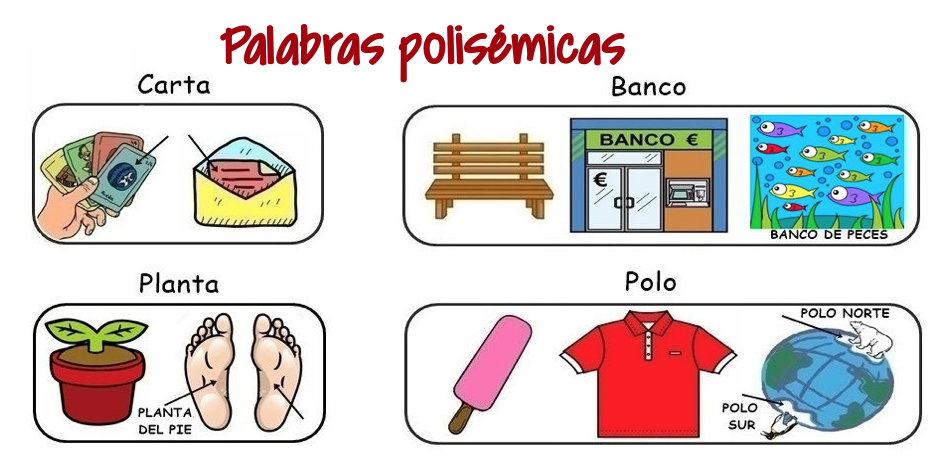

## Recurrent Neural Networks (RNN)

Las Redes Neuronales Recurrentes (RNN, por sus siglas en inglés) son un tipo de arquitectura de redes neuronales diseñadas para procesar datos secuenciales o temporales. A diferencia de las redes neuronales tradicionales, las RNN tienen conexiones recurrentes que les permiten mantener y utilizar información de estados anteriores en la secuencia.

La clave de las RNN radica en su capacidad para mantener una memoria interna o estado oculto que se actualiza y se propaga a lo largo de la secuencia de entrada. Esto les permite capturar patrones y dependencias a largo plazo en los datos secuenciales, lo cual es especialmente útil en tareas como el procesamiento del lenguaje natural, la traducción automática, el reconocimiento de voz y la generación de texto, entre otros.

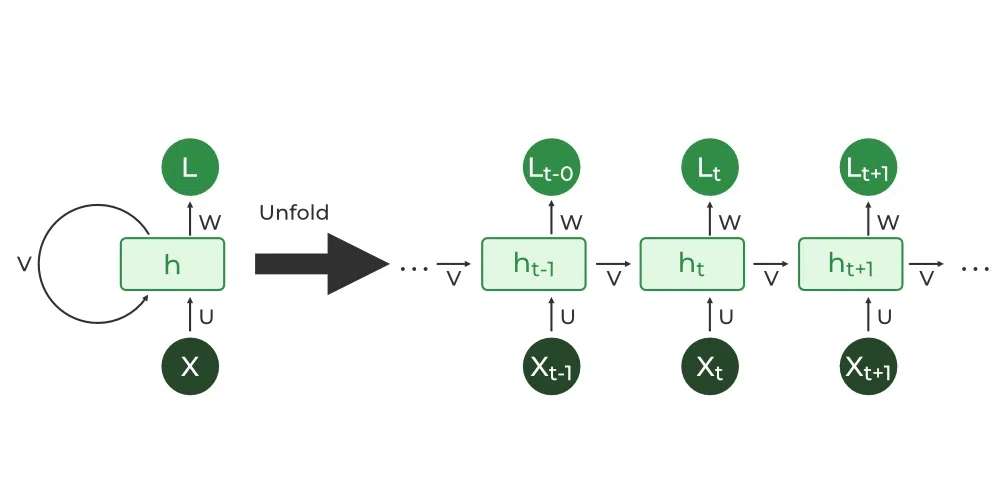

## Transformers

Transformers son una arquitectura de redes neuronales que han revolucionado el campo del procesamiento del lenguaje natural. A diferencia de las Redes Neuronales Recurrentes (RNN), los transformers se basan en una estructura de atención para capturar las relaciones y dependencias entre las palabras de una secuencia.

En lugar de procesar la secuencia de manera secuencial como lo hacen las RNN, los transformers procesan todas las palabras de entrada simultáneamente y calculan una representación contextual para cada palabra en función de las interacciones con todas las demás palabras de la secuencia. Esto se logra mediante mecanismos de atención, que permiten que cada palabra "atención" a diferentes partes de la secuencia para capturar la información relevante.

Los transformers se componen de múltiples capas de atención y transformación, conocidas como bloques de atención, que permiten que la red capture relaciones tanto a nivel local como global en el texto. Estos bloques de atención eliminan la necesidad de mantener una memoria recurrente, lo que hace que los transformers sean más eficientes en términos de cálculo y permiten capturar dependencias a largo plazo de manera más efectiva.

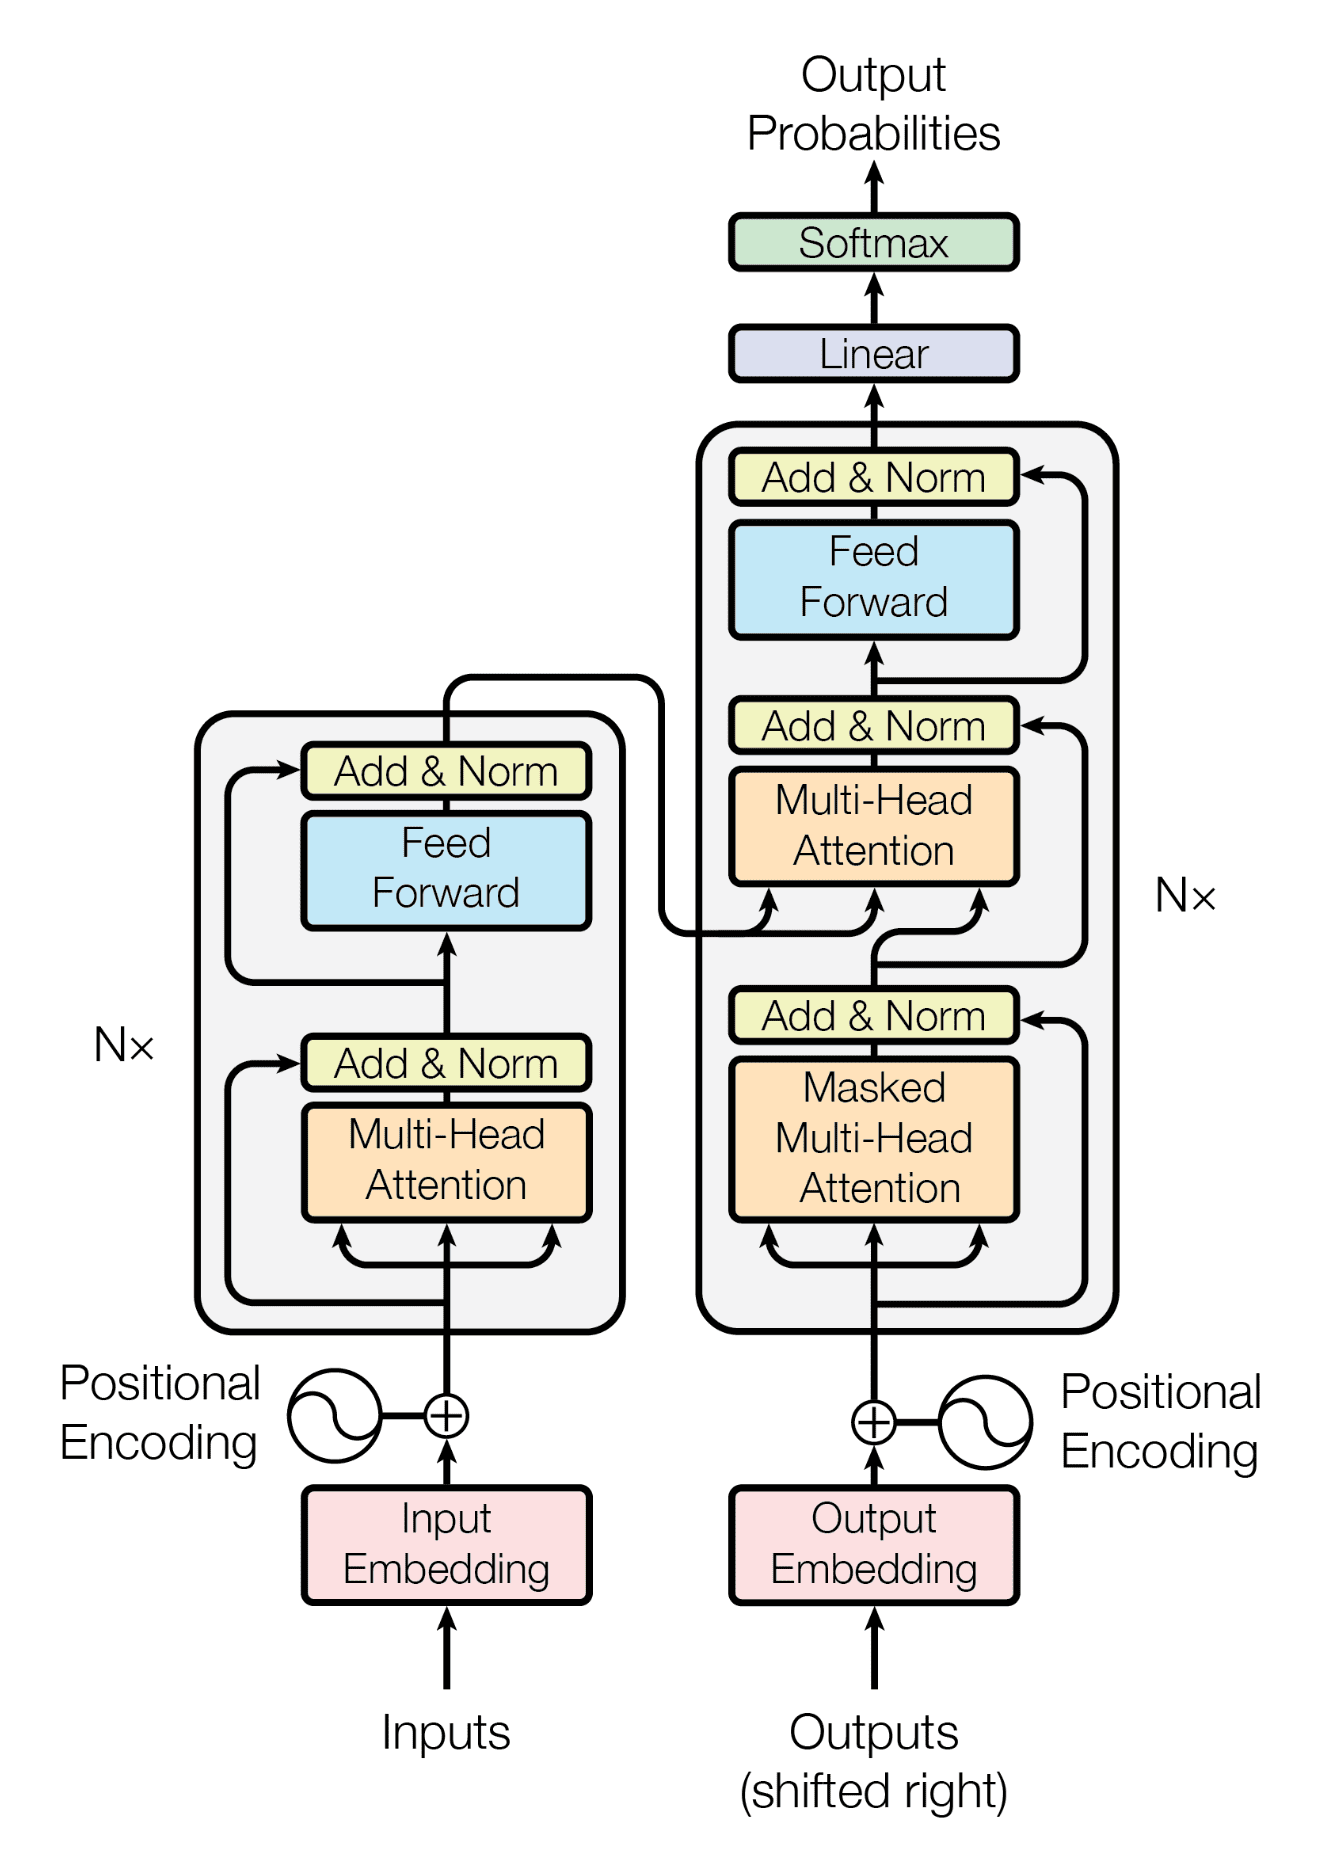

## Bidirectional Encoder Representations from Transformers (BERT)

BERT y BETO (BERT in Spanish) son modelos de lenguaje basados en transformers que han tenido un gran impacto en el procesamiento del lenguaje natural, especialmente en tareas como el entendimiento del lenguaje natural, la traducción automática y la generación de texto.

BERT, desarrollado por Google, es uno de los modelos de lenguaje pre-entrenados más conocidos y ampliamente utilizados. Se entrena en grandes corpus de texto sin etiquetar para aprender representaciones profundas y contextuales de las palabras. Una vez entrenado, BERT puede ser afinado o adaptado a tareas específicas mediante un entrenamiento adicional con datos etiquetados.

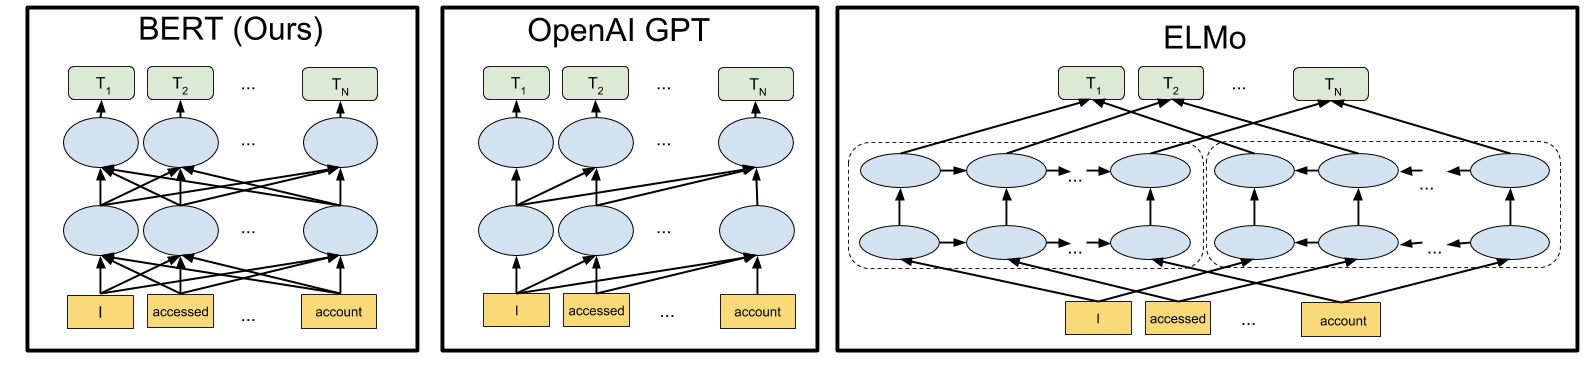

## Como usar BETO para Contextualized Word Embeddings

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 131.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.8 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import BertForMaskedLM, BertTokenizer



In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = AutoModelForMaskedLM.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

In [ ]:
def bert_text_preparation(text, tokenizer):
    """Preparing the input for BERT

    Takes a string argument and performs
    pre-processing like adding special tokens,
    tokenization, tokens to ids, and tokens to
    segment ids. All tokens are mapped to seg-
    ment id = 1.

    Args:
        text (str): Text to be converted
        tokenizer (obj): Tokenizer object
            to convert text into BERT-re-
            adable tokens and ids

    Returns:
        list: List of BERT-readable tokens
        obj: Torch tensor with token ids
        obj: Torch tensor segment ids


    """
    marked_text = "[MASK] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    return tokenized_text, tokens_tensor, segments_tensors

In [ ]:
def get_bert_embeddings(tokens_tensor, segments_tensors, model):
    """Get embeddings from an embedding model

    Args:
        tokens_tensor (obj): Torch tensor size [n_tokens]
            with token ids for each token in text
        segments_tensors (obj): Torch tensor size [n_tokens]
            with segment ids for each token in text
        model (obj): Embedding model to generate embeddings
            from token and segment ids

    Returns:
        list: List of list of floats of size
            [n_tokens, n_embedding_dimensions]
            containing embeddings for each token

    """
    # Gradient calculation id disabled
    # Model is in inference mode
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)

        # Removing the first hidden state
        # The first state is the input state
        #hidden_states = outputs[2][1:]
        #print(f'hiddens_states = {hidden_states}')

    # Getting embeddings from the final BERT layer
    token_embeddings = outputs[-1]

    # Collapsing the tensor into 1-dimension
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    #print("hola")
    #print(token_embeddings)
    # Converting torchtensors to lists
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

    return list_token_embeddings

In [ ]:
# Text corpus
##############
# These sentences show the different
# forms of the word 'bank' to show the
# value of contextualized embeddings

texts = ["café",
         "En la finca hay plantaciones de café.",
         "Tomemos un café.",
         "Vayamos al café de la esquina.",
         "Sus zapatos eran de color café."]

In [ ]:
# Getting embeddings for the target
# word in all given contexts
target_word_embeddings = []

for text in texts:
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(text, tokenizer)

    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
    # Find the position 'bank' in list of tokens
    word_index = tokenized_text.index('café')
    # Get the embedding for bank
    word_embedding = list_token_embeddings[word_index]

    target_word_embeddings.append(word_embedding)

In [ ]:
from scipy.spatial.distance import cosine

# Calculating the distance between the
# embeddings of 'café' in all the
# given contexts of the word

list_of_distances = []
for text1, embed1 in zip(texts, target_word_embeddings):
    for text2, embed2 in zip(texts, target_word_embeddings):
        cos_dist = 1 - cosine(embed1, embed2)
        list_of_distances.append([text1, text2, cos_dist])

distances_df = pd.DataFrame(list_of_distances, columns=['text1', 'text2', 'distance'])

In [ ]:
distances_df[distances_df.text1 == 'café']

,text1,text2,distance
0,café,café,1.000000
1,café,En la finca hay plantaciones de café.,0.863445
2,café,Tomemos un café.,0.843150
3,café,Vayamos al café de la esquina.,0.842981
4,café,Sus zapatos eran de color café.,0.850472


In [ ]:
distances_df[distances_df.text1 == 'En la finca hay plantaciones de café.']

,text1,text2,distance
5,En la finca hay plantaciones de café.,café,0.863445
6,En la finca hay plantaciones de café.,En la finca hay plantaciones de café.,1.000000
7,En la finca hay plantaciones de café.,Tomemos un café.,0.816064
8,En la finca hay plantaciones de café.,Vayamos al café de la esquina.,0.832717
9,En la finca hay plantaciones de café.,Sus zapatos eran de color café.,0.883720


# Referencias

* [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781)
* [GloVe: Global Vectors for Word Representation
](https://nlp.stanford.edu/pubs/glove.pdf).
* [Gensim: Topic modelling for humans](https://radimrehurek.com/gensim/auto_examples/index.html).
* [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805).
* [BETO: Spanish BERT](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased).
* [RiverText: A Python Library for Training and Evaluating Incremental Word Embeddings from Text Data Streams](https://dl.acm.org/doi/10.1145/3539618.3591908)